# Letters

## Description

Generate an image with the edges of the letters present in this noisy image


## Group ID

Identify your group here, including the number and name of each group's member

In [98]:
import cv2
# to install cv2 use: pip install opencv-python
import matplotlib.pyplot as plt 
import numpy as np

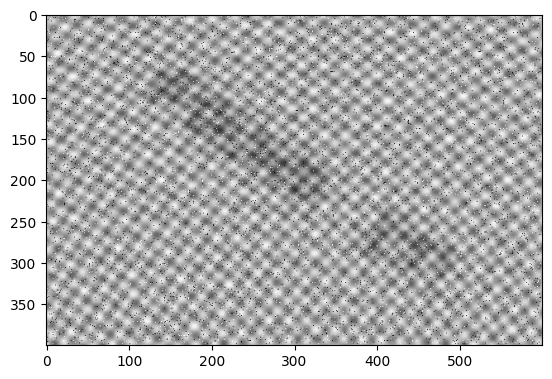

In [99]:
fname = 'Letters-noisy.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
#print('Image Shape =', img.shape())
plt.imshow(img, cmap = 'gray')

# convert the image representation to SPFP
img_float32 = np.float32(img)

# Black and White Noise

First thing first we removed all the white and black noise pixels

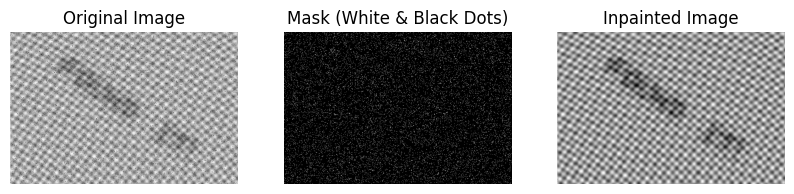

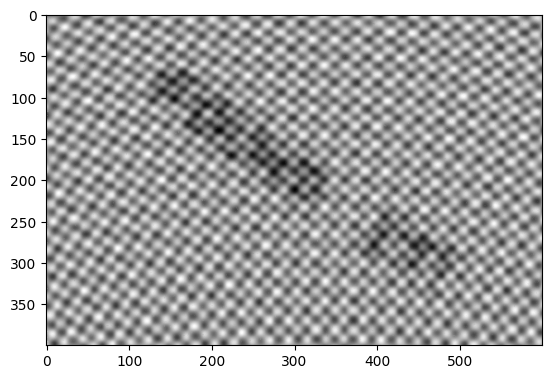

In [100]:
mask = (img == 0) | (img == 255)
mask = mask.astype(np.uint8) * 255  # Convert boolean mask to uint8 format

# Inpaint the noisy pixels
inpainted = cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
inpainted_float32 = np.float32(inpainted)

# Display results using Matplotlib
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Mask (White & Black Dots)")
ax[1].axis("off")

ax[2].imshow(inpainted, cmap='gray')
ax[2].set_title("Inpainted Image")
ax[2].axis("off")

plt.show()

# show only the impainted image
plt.imshow(inpainted, cmap = 'gray')
plt.show()


# Analyzing the Images Frequencies and Mangnitudes

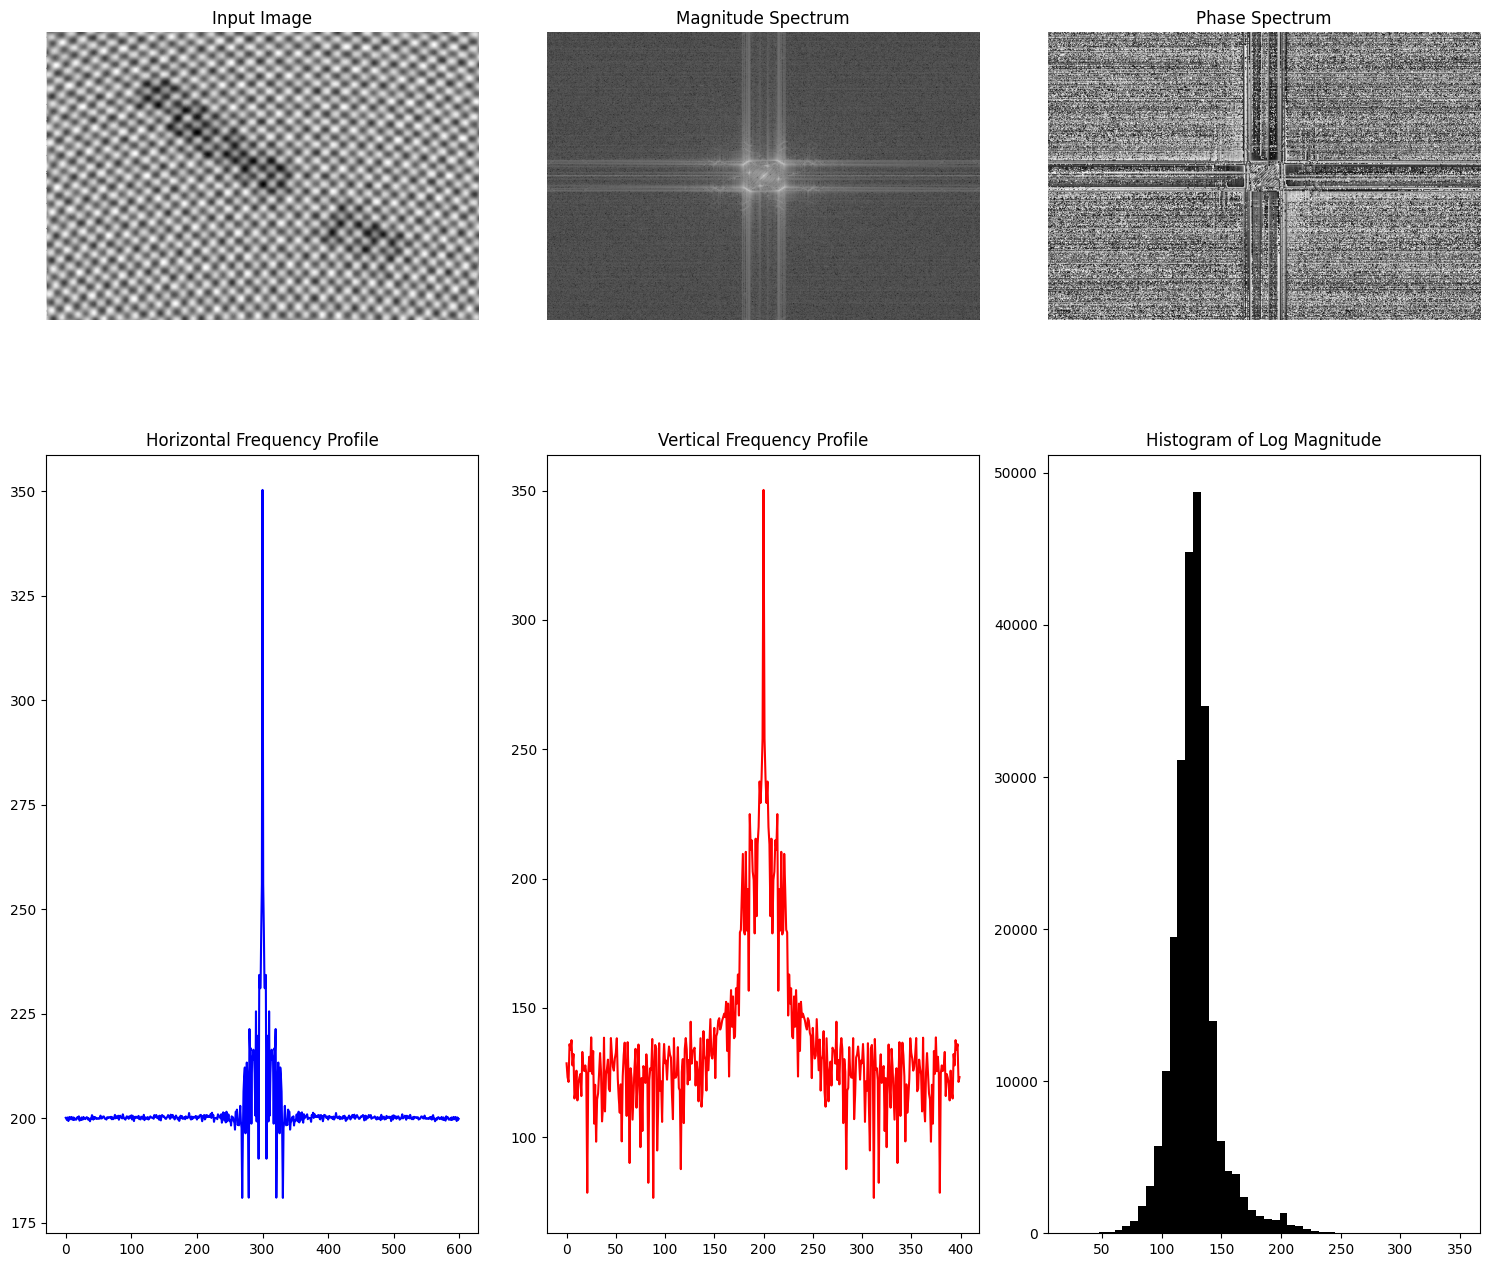

In [101]:
# Compute the DFT
dft = cv2.dft(inpainted_float32, flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# Compute magnitude and phase spectra
magnitude = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
phase = np.arctan2(dft_shift[:, :, 1], dft_shift[:, :, 0])

log_magnitude = 20 * np.log1p(magnitude)  # log1p to avoid log(0) errors

center_x, center_y = magnitude.shape[1] // 2, magnitude.shape[0] // 2
horizontal_profile = log_magnitude[center_y, :]
vertical_profile = log_magnitude[:, center_x]

real_only = np.fft.ifftshift(np.stack([magnitude, np.zeros_like(magnitude)], axis=2))
img_reconstructed_magnitude = cv2.idft(real_only)
img_reconstructed_magnitude = cv2.magnitude(img_reconstructed_magnitude[:, :, 0], img_reconstructed_magnitude[:, :, 1])

phase_only = np.fft.ifftshift(np.stack([np.cos(phase), np.sin(phase)], axis=2))
img_reconstructed_phase = cv2.idft(phase_only)
img_reconstructed_phase = cv2.magnitude(img_reconstructed_phase[:, :, 0], img_reconstructed_phase[:, :, 1])


fig, axes = plt.subplots(2, 3, figsize=(15, 15))

# Input Image
axes[0, 0].imshow(inpainted, cmap='gray')
axes[0, 0].set_title('Input Image')
axes[0, 0].axis('off')

# Magnitude Spectrum
axes[0, 1].imshow(log_magnitude, cmap='gray')
axes[0, 1].set_title('Magnitude Spectrum')
axes[0, 1].axis('off')

# Phase Spectrum
axes[0, 2].imshow(phase, cmap='gray')
axes[0, 2].set_title('Phase Spectrum')
axes[0, 2].axis('off')

# Horizontal Frequency Profile
axes[1, 0].plot(horizontal_profile, color='blue')
axes[1, 0].set_title('Horizontal Frequency Profile')

# Vertical Frequency Profile
axes[1, 1].plot(vertical_profile, color='red')
axes[1, 1].set_title('Vertical Frequency Profile')

# Histogram of Log Magnitude
axes[1, 2].hist(log_magnitude.ravel(), bins=50, color='black')
axes[1, 2].set_title('Histogram of Log Magnitude')

plt.tight_layout()
plt.show()


# Notch Filters

We tried to use regular notch filters to remove the "checkboard" like noise.

In [102]:
# Compute the DFT
dft = cv2.dft(inpainted_float32, flags=cv2.DFT_COMPLEX_OUTPUT)

# Recenter the DFT
dft_shift = np.fft.fftshift(dft)

filtered_dft = dft_shift

# Get image dimensions
rows, cols = inpainted_float32.shape
crow, ccol = rows // 2 , cols // 2  # Center coordinates

# Define Notch Filter Centers
notch_centers = [(ccol - 30, crow - 20, 10), (ccol + 30, crow + 20, 10), (ccol - 30, crow + 20, 10), (ccol + 30, crow - 20, 10),
                 (ccol + 20, crow, 5), (ccol - 20, crow, 5), (ccol - 5, crow + 10, 5), (ccol + 5, crow - 10, 5)
                ]

# Donut Filter Centers
donut_centers = []

### Regular Notch Filter

In [103]:
def create_notch_filter(shape, notch_centers):
    mask = np.ones((shape[0], shape[1], 2), np.uint8)
    for center in notch_centers:
        x, y, r = center
        cv2.circle(mask, (x, y), r, (0, 0), thickness=-1)
    return mask

# Create Notch Filter Mask
notch_mask = create_notch_filter((rows, cols), notch_centers)

### Donut Filters

In order to try different approaches we decided to use a donut like mask instead of the regular circle

In [104]:
def create_donut_filter(shape, donut_centers):
    """Creates a donut (ring-shaped) notch filter."""
    mask = np.ones((shape[0], shape[1], 2), np.float32)
    
    for center in donut_centers:
        x, y, outer_r, inner_r = center
        cv2.circle(mask, (x, y), outer_r, (0, 0), thickness=-1)
        cv2.circle(mask, (x, y), inner_r, (1, 1), thickness=-1) 

    return cv2.GaussianBlur(mask, (5, 5), 0) 

# Create Donut Filter Mask
donut_mask = create_donut_filter((rows, cols), donut_centers)

### Result

Now depending on what we applied before we can get the final result.
Overall the donut approach didn't prove to be that useful but it was a fun idea.

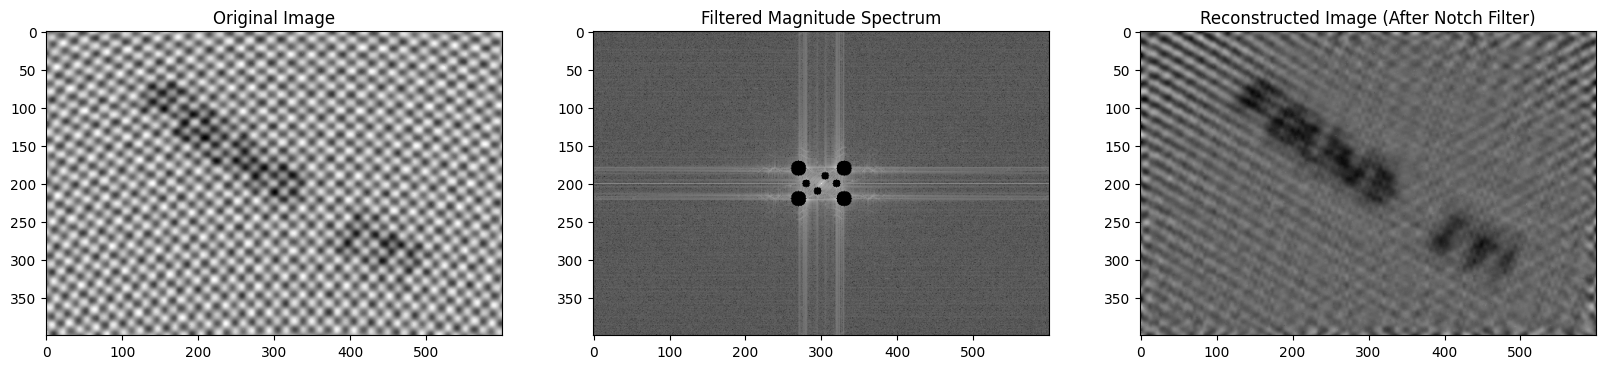

In [105]:
# Apply Notch Filter and Donut Filter
filtered_dft *=  notch_mask
filtered_dft *= donut_mask

# Compute the magnitude spectrum (for visualization)
magnitude_spectrum = cv2.magnitude(filtered_dft[:, :, 0], filtered_dft[:, :, 1])
magnitude_spectrum = 20 * np.log(magnitude_spectrum + 1)

# Inverse DFT
idft_shift = np.fft.ifftshift(filtered_dft)
reconstructed = cv2.idft(idft_shift)
reconstructed = cv2.magnitude(reconstructed[:, :, 0], reconstructed[:, :, 1])

# Normalize for display
reconstructed = cv2.normalize(reconstructed, None, 0, 255, cv2.NORM_MINMAX)
reconstructed = np.uint8(reconstructed)

# Display Results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(inpainted, cmap='gray')
axes[0].set_title('Original Image')

axes[1].imshow(magnitude_spectrum, cmap='gray')
axes[1].set_title('Filtered Magnitude Spectrum')

axes[2].imshow(reconstructed, cmap='gray')
axes[2].set_title('Reconstructed Image (After Notch Filter)')

plt.show()

### Inverted Notch Filters

Let's try the other way around

In [106]:
def create_inverted_notch_filter(shape, notch_centers):
    mask = np.zeros((shape[0], shape[1], 2), np.uint8)  # Start with zeros
    for center in notch_centers:
        x, y, r = center
        cv2.circle(mask, (x, y), r, (1, 1), thickness=-1)  # Set circles to 1
    return mask

notch_centers = [(ccol, crow, 40)]

# Create Inverted Notch Filter Mask
inverted_notch_mask = create_inverted_notch_filter((rows, cols), notch_centers)

### Result

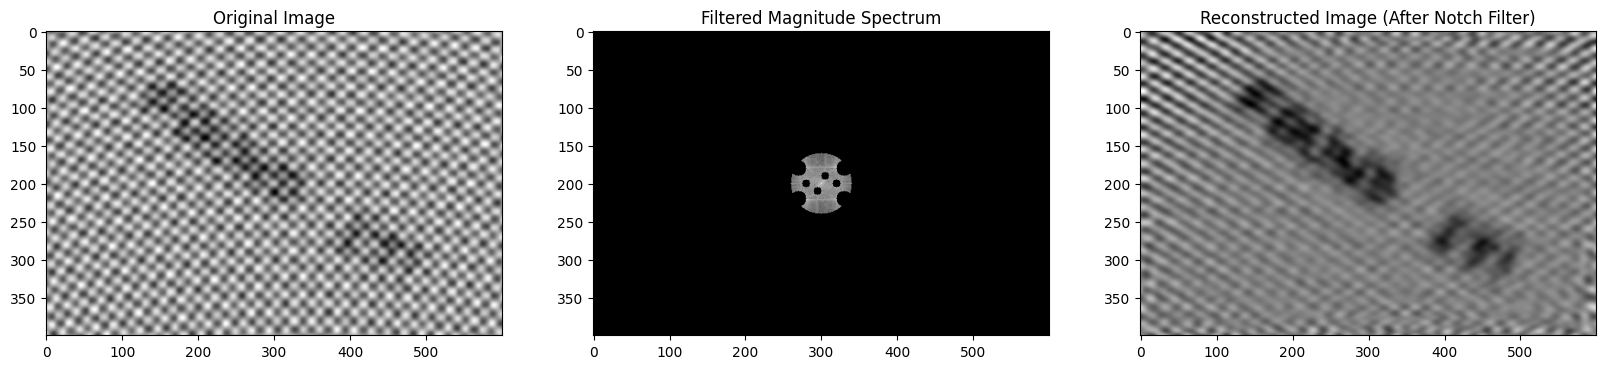

In [107]:
filtered_dft = dft_shift
filtered_dft *= inverted_notch_mask
# Use notch normal notch as well
filtered_dft *= notch_mask

magnitude_spectrum = cv2.magnitude(filtered_dft[:, :, 0], filtered_dft[:, :, 1])
magnitude_spectrum = 20 * np.log(magnitude_spectrum + 1)

# Inverse DFT
idft_shift = np.fft.ifftshift(filtered_dft)
reconstructed = cv2.idft(idft_shift)
reconstructed = cv2.magnitude(reconstructed[:, :, 0], reconstructed[:, :, 1])

# Normalize for display
reconstructed = cv2.normalize(reconstructed, None, 0, 255, cv2.NORM_MINMAX)
reconstructed_int8 = np.uint8(reconstructed)

# Display Results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(inpainted, cmap='gray')
axes[0].set_title('Original Image')

axes[1].imshow(magnitude_spectrum, cmap='gray')
axes[1].set_title('Filtered Magnitude Spectrum')

axes[2].imshow(reconstructed_int8, cmap='gray')
axes[2].set_title('Reconstructed Image (After Notch Filter)')

plt.show()

# Frequency Filters

Testing out Low and High Frequency Filters 

In [108]:
# List with and without the applied notch filters
photos = [(inpainted_float32, inpainted), (reconstructed, reconstructed_int8)]


### High-Pass Frequency Filter

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

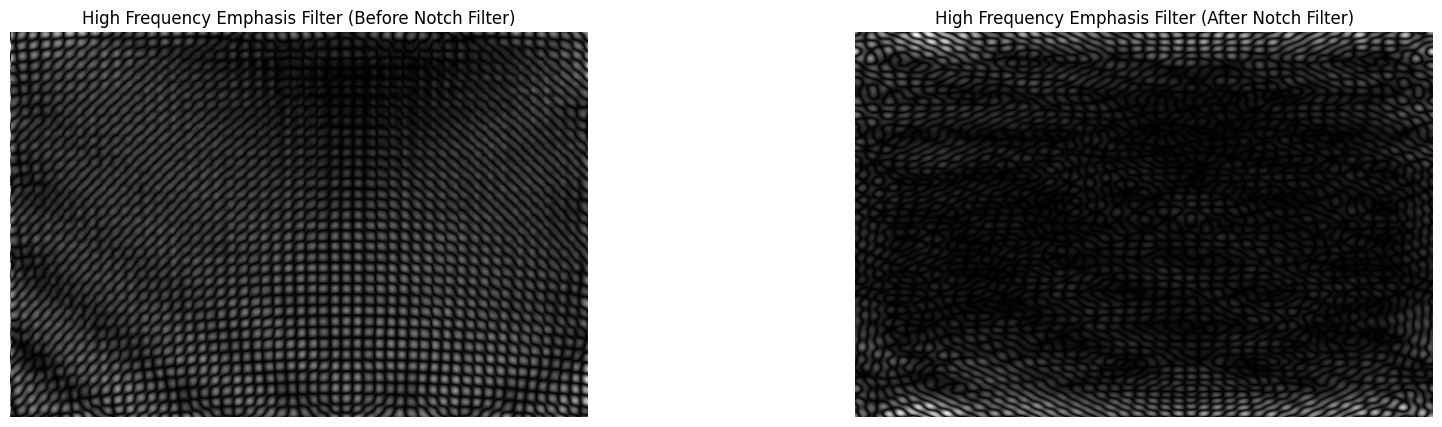

In [109]:
# High Frequency Emphasis Filter

imgs = []

for photo in photos:
    # Compute the DFT
    dft = cv2.dft(photo[0], flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    # Get image dimensions
    row, cols = photo[1].shape
    center_x, center_y = cols // 2, rows // 2

    # Create a mask for High-Pass Filter (HPF)
    high_pass_radius = 30  # Adjust as needed
    high_pass_mask = np.ones((rows, cols, 2), np.uint8)
    cv2.circle(high_pass_mask, (center_x, center_y), high_pass_radius, (0, 0), -1)

    # Apply High-Pass Filter
    high_pass_dft = dft_shift * high_pass_mask
    high_pass_dft_shift = np.fft.ifftshift(high_pass_dft)  # Recenter for inverse DFT
    high_pass_img = cv2.idft(high_pass_dft_shift)
    high_pass_img = cv2.magnitude(high_pass_img[:, :, 0], high_pass_img[:, :, 1])  # Get magnitude
    imgs.append(high_pass_img)

# Show result
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].imshow(imgs[0], cmap='gray')
axes[0].set_title('High Frequency Emphasis Filter (Before Notch Filter)')
axes[0].axis('off')

axes[1].imshow(imgs[1], cmap='gray')
axes[1].set_title('High Frequency Emphasis Filter (After Notch Filter)')
axes[1].axis('off')



### Low-Pass Frequency Filter

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

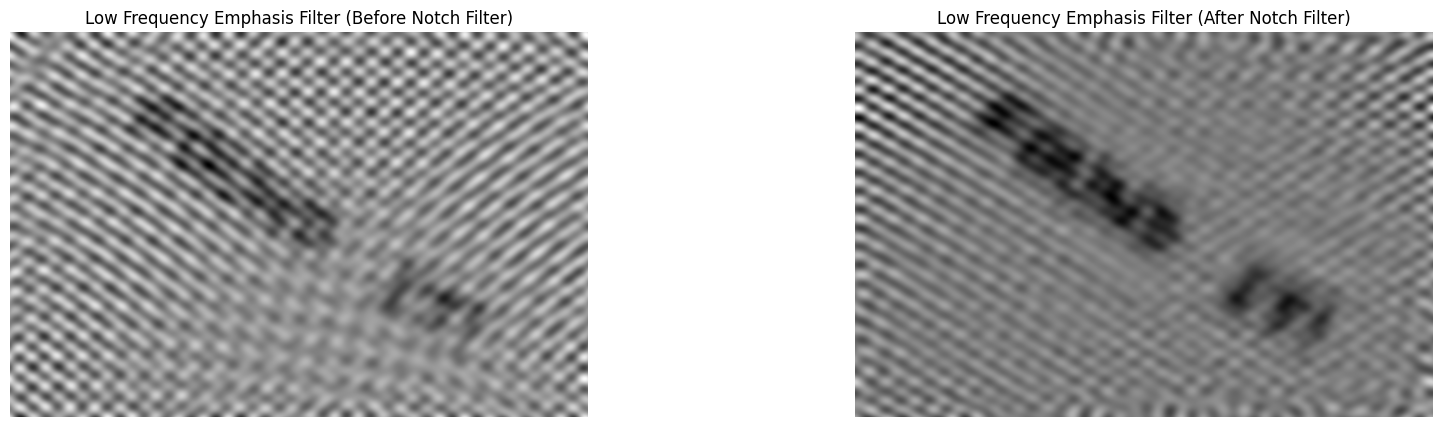

In [110]:
# Low Frequency Emphasis Filter

imgs = []

for photo in photos:
    # Compute the DFT
    dft = cv2.dft(photo[0], flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    # Get image dimensions
    rows, cols = photo[1].shape
    center_x, center_y = cols // 2, rows // 2

    # Create a mask for Low-Pass Filter (LPF)
    low_pass_radius = 30  # Adjust as needed
    low_pass_mask = np.zeros((rows, cols, 2), np.uint8)
    cv2.circle(low_pass_mask, (center_x, center_y), low_pass_radius, (1, 1), -1)

    # Apply Low-Pass Filter
    low_pass_dft = dft_shift * low_pass_mask
    low_pass_dft_shift = np.fft.ifftshift(low_pass_dft)  # Recenter for inverse DFT
    low_pass_img = cv2.idft(low_pass_dft_shift)
    low_pass_img = cv2.magnitude(low_pass_img[:, :, 0], low_pass_img[:, :, 1])  # Get magnitude
    imgs.append(low_pass_img)

# Show result
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].imshow(imgs[0], cmap='gray')
axes[0].set_title('Low Frequency Emphasis Filter (Before Notch Filter)')
axes[0].axis('off')

axes[1].imshow(imgs[1], cmap='gray')
axes[1].set_title('Low Frequency Emphasis Filter (After Notch Filter)')
axes[1].axis('off')


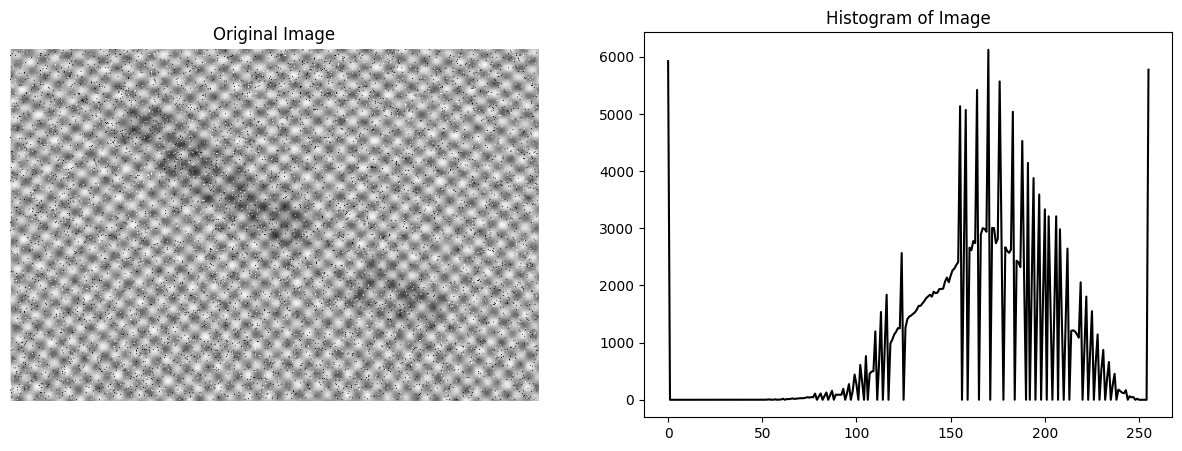

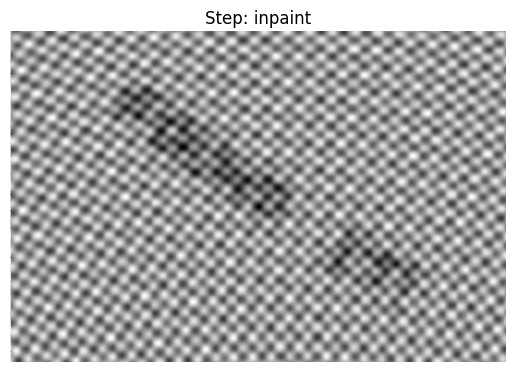

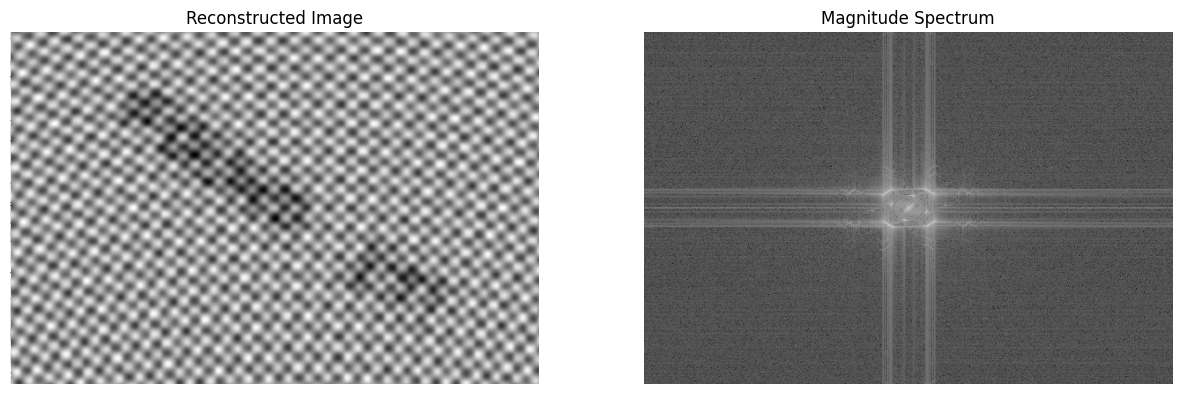

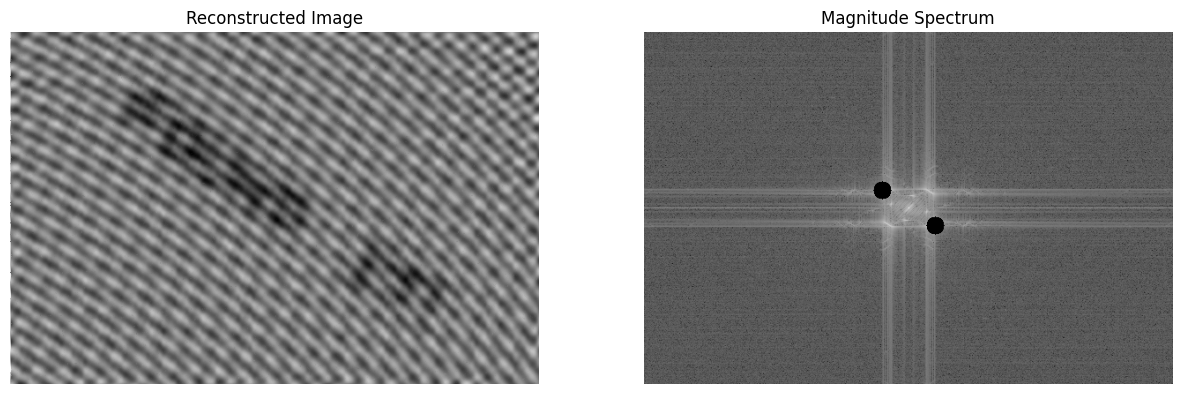

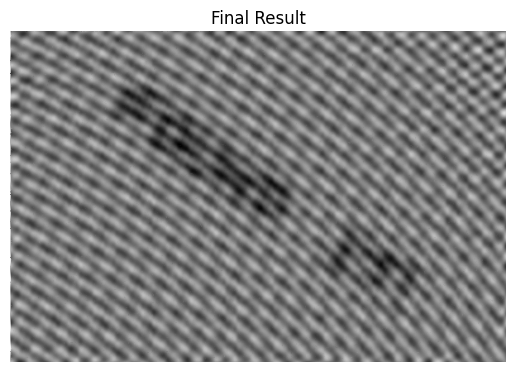

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Image
def load_image(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    hist = analyze_image(img)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].plot(hist, color='black')
    axes[1].set_title('Histogram of Image')
    plt.show()

    return np.float32(img)

# Inpainting
def inpaint_image(img):
    mask = (img == 0) | (img == 255)
    mask = mask.astype(np.uint8) * 255
    return cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Compute DFT
def compute_dft(img):
    dft = cv2.dft(img, flags=cv2.DFT_COMPLEX_OUTPUT)
    return np.fft.fftshift(dft)

# Apply Notch Filter
def apply_notch_filter(dft):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    notch_centers = [(ccol - 30, crow - 20, 10), (ccol + 30, crow + 20, 10)]
    mask = np.ones((rows, cols, 2), np.uint8)
    for x, y, r in notch_centers:
        cv2.circle(mask, (x, y), r, (0, 0), -1)
    return dft * mask

# Apply Donut Notch Filter
def apply_donut_notch_filter(dft):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols, 2), np.uint8)
    inner_radius, outer_radius = 10, 30
    cv2.circle(mask, (ccol, crow), outer_radius, (0, 0), -1)
    cv2.circle(mask, (ccol, crow), inner_radius, (1, 1), -1)
    return dft * mask

# Apply Inversed Notch Filter
def apply_inversed_notch_filter(dft):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols, 2), np.uint8)
    notch_centers = [(ccol - 30, crow - 20, 10), (ccol + 30, crow + 20, 10)]
    for x, y, r in notch_centers:
        cv2.circle(mask, (x, y), r, (1, 1), -1)
    return dft * mask

# Reconstruct Image
def reconstruct_image(dft):
    dft = np.fft.ifftshift(dft)
    img_back = cv2.idft(dft)
    return cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])


# Unified plotting function
def plot_result(data, title):
    if data.ndim == 2:  # Spatial domain
        plt.figure()
        plt.title(title)
        plt.imshow(data, cmap='gray')
        plt.axis('off')
        plt.show()
    elif data.ndim == 3 and data.shape[-1] == 2:  # Frequency domain
        magnitude_spectrum = 20 * np.log(cv2.magnitude(data[:, :, 0], data[:, :, 1]) + 1)
        img = reconstruct_image(data)
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Reconstructed Image')
        axes[0].axis('off')
        
        axes[1].imshow(magnitude_spectrum, cmap='gray')
        axes[1].set_title('Magnitude Spectrum')
        axes[1].axis('off')
        plt.show()

# Define operation pipeline
operations = {
    "inpaint": inpaint_image,
    "dft": compute_dft,
    "notch_filter": apply_notch_filter,
    "donut_notch_filter": apply_donut_notch_filter,
    "inversed_notch_filter": apply_inversed_notch_filter,
}

# Define execution order
pipeline_order = ["inpaint", "dft", "notch_filter"]

# Execute pipeline
fname = 'Letters-noisy.png'
data = load_image(fname)
for step in pipeline_order:
    data = operations[step](data)
    
    plot_result(data, f"Step: {step}")

data = reconstruct_image(data)
plot_result(data, "Final Result")
